<a href="https://colab.research.google.com/github/hoihui/tutorial/blob/master/ImageTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install -U torch torchvision
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.__version__, cuda

('1.1.0', True)

In [3]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
tf.__version__

     |████████████████████████████████| 332.1MB 57kB/s 
     |████████████████████████████████| 419kB 51.8MB/s 
     |████████████████████████████████| 61kB 22.0MB/s 
     |████████████████████████████████| 3.0MB 54.5MB/s 


'2.0.0-alpha0'

[Ref](https://towardsdatascience.com/cyclegans-and-pix2pix-5e6a5f0159c4)

# Pix2Pix w/ tensorflow

https://www.tensorflow.org/alpha/tutorials/generative/pix2pix

* Use a conditional GAN (cGAN) to learn a mapping from an input image to an output image.
* The training set must have a tight one-to-one correspondence between input and output. (paired)

## Data

In [0]:
IMG_WIDTH = IMG_HEIGHT = 256
BATCH_SIZE = 1
BUFFER_SIZE = 400

In [0]:
import os, tempfile, urllib, tarfile
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve('https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz',
                           'facades.tar.gz')
tarfile.open('facades.tar.gz','r:gz').extractall()

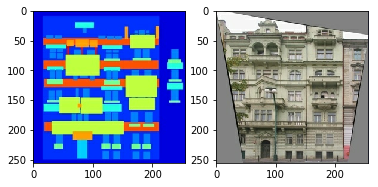

In [6]:
image = tf.image.decode_jpeg(tf.io.read_file('facades/train/100.jpg'))
input_img = tf.cast(image[:,IMG_WIDTH:,:], tf.float32)   # the image is juxtapose [real,input(facades)]
real_img = tf.cast(image[:,:IMG_WIDTH,:], tf.float32)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(input_img/255.0)
ax2.imshow(real_img/255.0)

### Loader

In [0]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)    
    real_image =  tf.cast(image[:, :IMG_WIDTH, :], tf.float32)
    input_image = tf.cast(image[:, IMG_WIDTH:, :], tf.float32)
    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
                      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)
    if tf.random.uniform(()) > 0.5:   #(randomly)
        input_image = tf.image.flip_left_right(input_image)
        real_image  = tf.image.flip_left_right(real_image)
    return input_image, real_image

def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                     IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [0]:
train_dataset = tf.data.Dataset.list_files('facades/train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files('facades/test/*.jpg')
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

## Model

### Generator

* Modified U-Net <img src="https://cdn-images-1.medium.com/max/1600/1*kpWvVdQOmbMuX2ls-d78TA.png" width="500px">
* Encoder (downsampler) block: (Conv -> Batchnorm -> Leaky ReLU)
* Decoder (upsampler) block: (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
* Skip connections

In [0]:
initializer = tf.random_normal_initializer(0., 0.02)
    
def downsampler(filters, size=4, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add( tf.keras.layers.Conv2D(filters, size, strides=2, #strides=2 => downsamples by 0.5
                                       padding='same',
                                       kernel_initializer=initializer,
                                       use_bias=False))
    if apply_batchnorm:  result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsampler(filters, size=4, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose( filters, size, strides=2,
                                                padding='same',
                                                kernel_initializer=initializer,
                                                use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout: result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [13]:
down_stack = [
    downsampler(64, apply_batchnorm=False), # out (batchsize, 128, 128, 64)
    downsampler(128), # (bs, 64, 64, 128)
    downsampler(256), # (bs, 32, 32, 256)
    downsampler(512), # (bs, 16, 16, 512)
    downsampler(512), # (bs, 8, 8, 512)
    downsampler(512), # (bs, 4, 4, 512)
    downsampler(512), # (bs, 2, 2, 512)
    downsampler(512), # (bs, 1, 1, 512)
]
up_stack = [
    upsampler(512, apply_dropout=True), # (bs, 2, 2, 512)
    upsampler(512, apply_dropout=True), # (bs, 4, 4, 512)
    upsampler(512, apply_dropout=True), # (bs, 8, 8, 512)
    upsampler(512), # (bs, 16, 16, 512)
    upsampler(256), # (bs, 32, 32, 256)
    upsampler(128), # (bs, 64, 64, 128)
    upsampler(64),  # (bs, 128, 128, 64)
]
last = tf.keras.layers.Conv2DTranspose( 3, 4,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        activation='tanh') # (bs, 256, 256, 3)
concat = tf.keras.layers.Concatenate()

inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,3])
x = inputs

skips = []
for down in down_stack:
    x = down(x)
    skips.append(x)

for up, skip in zip(up_stack, skips[-2::-1]):
    x = up(x)
    x = concat([x, skip])


x = last(x)
G = tf.keras.Model(inputs=inputs, outputs=x)
G.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

In [0]:
gen_output = G(input_img[tf.newaxis,...], training=False)

### Discriminator

* PatchGAN <img src="https://cdn-images-1.medium.com/max/1600/1*-iPXj4C0sCK0UzW1aPzJZg.png" width="600px">
* receives 2 inputs. (concatenated as a simple list)
   - Input image and the target image, which it should classify as real.
   - Input image and the generated image (output of generator), which it should classify as fake.
* each pixel from the 30x30 output corresponds to the believability of a 70x70 patch of the input image

In [0]:
initializer = tf.random_normal_initializer(0., 0.02)

inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
down1 = downsampler(64, apply_batchnorm=False)(x) # (bs, 128, 128, 64)
down2 = downsampler(128)(down1) # (bs, 64, 64, 128)
down3 = downsampler(256)(down2) # (bs, 32, 32, 256)

zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)     # (bs, 34, 34, 256)
conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                              kernel_initializer=initializer,
                              use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

last = tf.keras.layers.Conv2D(1, 4, strides=1,
                              kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

D = tf.keras.Model(inputs=[inp, tar], outputs=last)

In [16]:
gen_output = G(input_img[tf.newaxis,...], training=False)
dis_output = D([input_img[tf.newaxis,...], gen_output])
dis_output.shape # Each 30x30 patch of the output classifies a 70x70 portion of the input image

TensorShape([1, 30, 30, 1])

### Losses and optimizer

In [0]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def d_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss   # loss from classifying real as fake or vice versa
    return total_disc_loss

def g_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)  # loss driving fake img to be classified as real by D, and driving fake to true (provided) img
    return total_gen_loss

g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Train

### Checkpoint

In [0]:
checkpoint_dir = tempfile.gettempdir()
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(g_optimizer=g_optimizer,
                                 d_optimizer=d_optimizer,
                                 G=G,
                                 D=D)

### Visualization tool

In [0]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

### Step

In [0]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        g_output = G(input_image, training=True)

        d_real_output = D([input_image, target], training=True)
        d_generated_output = D([input_image, g_output], training=True)

        g_loss_ = g_loss(d_generated_output, gen_output, target)
        d_loss_ = d_loss(d_real_output, d_generated_output)

    g_grad = g_tape.gradient(g_loss_, G.trainable_variables)
    d_grad = d_tape.gradient(d_loss_, D.trainable_variables)

    g_optimizer.apply_gradients(zip(g_grad, G.trainable_variables))
    d_optimizer.apply_gradients(zip(d_grad, D.trainable_variables))

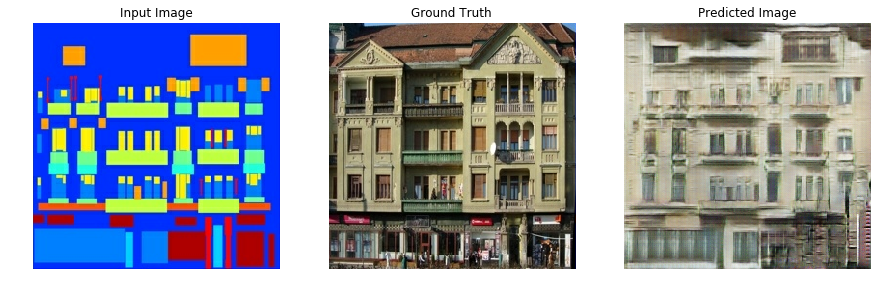

In [24]:
from IPython.display import clear_output
def train(dataset, epochs):
    for _ in range(epochs):
        for input_image, target in dataset:
            train_step(input_image, target)

        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(G, inp, tar)

        checkpoint.save(file_prefix = checkpoint_prefix)

train(train_dataset, 100)

### Test

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
for inp, tar in test_dataset.take(10):
    generate_images(G, inp, tar)

# CycleGAN w/ torch

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/CycleGAN_Solution.ipynb
* Given two sets of images X & Y
* Transform an image from X so that it looks as if it belongs in Y
* No strict 1-to-1 correspondence between X & Y. e.g. X = photos in summer, Y = photos in winter, unpaired (i.e. unsupervised)

## Data